<a href="https://colab.research.google.com/github/SI1000-github/PDE_on_MG/blob/main/Heat_Equation_on_MG2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from math import sqrt
import numpy as np

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import animation, rc

In [ ]:
"""  問題によって編集するセル  """

##########################
### 方程式のパラメータ ###
##########################
#  u_t = D*u_xx
#  with Kirchhoff boundary conditions

# 拡散係数
D = 1

"""
初期条件は３つ下のコードセルで設定する
"""

####################
### グラフの定義 ###
####################

# node_pos[node_id] = (x,y) -> 頂点 N_{node_id} が二次元座標 (x,y) に存在
node_pos = {}
node_pos[0] = (0,0)
node_pos[1] = (1,0)
node_pos[2] = (2,0)
node_pos[3] = (0,1)
node_pos[4] = (1,1)
node_pos[5] = (2,1)
node_pos[6] = (0,2)
node_pos[7] = (1,2)
node_pos[8] = (2,2)


# edge[edge_id] = (u,v) -> 辺 I_{edge_id} が頂点 N_u と N_v を結ぶ（無向辺と考えて良い）
# 辺の長さは頂点間のユークリッド距離によって自動的に決まる．
edge = {}
edge[0] = (0,3)
edge[1] = (1,4)
edge[2] = (2,4)
edge[3] = (3,4)
edge[4] = (4,5)
edge[5] = (3,7)
edge[6] = (7,4)
edge[7] = (7,5)
edge[8] = (6,7)
edge[9] = (7,8)


##################################
### 数値計算におけるパラメータ ###
##################################

# 空間離散化幅（辺に依存せず一定）
dx = 0.05

# 時間刻み幅
dt = 0.001

# 計算終了時間
endtime = 5

# 数値解を保存する間隔（時間 plotstep*dt 刻みで保存される）
plotstep = 200


In [ ]:
"""  編集不要のセル  """

## 上記のパラメータ設定から決まる種々の値の計算

node_num = len(node_pos)
edge_num = len(edge)

L = {} # 各辺の長さ（頂点の座標からユークリッドノルムに基づく距離で決まる．）
X = {} # 各辺のブロックの端の座標（両端の仮想ブロックを含まない）
Xc = {} # 各辺のブロックの中心の座標（両端の仮想ブロックを含む）
for edge_id in range(edge_num):
    u_pos = np.array(node_pos[edge[edge_id][0]])
    v_pos = np.array(node_pos[edge[edge_id][1]])

    L[edge_id] = np.linalg.norm(u_pos-v_pos, ord=2)

    X[edge_id] = np.arange(0, L[edge_id]+dx/2, dx)
    Xc[edge_id] = np.r_[-dx/2, X[edge_id]+dx/2]

# Kirchhoff 境界条件を満たすように仮想ブロック上状態変数を更新するために
# 必要なグラフの情報を保存
graph = [[] for _ in range(node_num)]
for edge_id,I in edge.items():
    graph[I[0]].append((edge_id,"s"))
    graph[I[1]].append((edge_id,"t"))


In [ ]:
"""  編集不要のセル  """

# Kirchhoff境界条件を満たしていない tmp_U の仮想ブロック上の値を修正して
# Kirchhoff境界条件を満たす U をリターンする関数
def Kirchhoff_Interpolation(tmp_U, graph):

    node_num = len(graph)
    U = tmp_U
    
    # 接合条件によるノード上の値の更新
    for node_id in range(node_num):
        U_on_Node = 0
        deg = len(graph[node_id])

        # ノード上の値の計算
        for edge_id, edge_dirc in graph[node_id]:
            if edge_dirc == "s": # 辺 I_{edge_id} が頂点 N_{node_id} に始点として繋がっている場合
                U_on_Node += U[edge_id][1]/deg
            else: # 上記と逆の場合
                U_on_Node += U[edge_id][-2]/deg

        # 仮想ブロック上の値の更新
        for edge_id, edge_dirc in graph[node_id]:
            if edge_dirc == "s": # 辺 I_{edge_id} が頂点 N_{node_id} に始点として繋がっている場合
                U[edge_id][0] = 2*U_on_Node - U[edge_id][1]
            else: # 上記と逆の場合
                U[edge_id][-1] = 2*U_on_Node - U[edge_id][-2]

    return U


In [ ]:
"""  問題によって編集するセル  """

################
### 初期条件 ###
################
U = {}
for edge_id in range(edge_num):
    U[edge_id] = np.zeros(Xc[edge_id].shape)

U[0] = np.ones(Xc[0].shape)
U[1] = np.ones(Xc[1].shape)



"""  以下は編集不要  """
# 仮想ブロック上の値を Kirchhoff 境界条件を満たすように変更する
U = Kirchhoff_Interpolation(U, graph)

################
### 数値計算 ###
################

R = D*dt/(dx**2)

assert dt < dx**2/(2*D), "not satisfying stable condition"

tlist = [0] # 数値解を保存した時間
U_save = {} # 各区間のブロック端の数値解を保存（プロットの都合）
U_save[len(tlist)-1] = {}
for i in range(edge_num):
    U_save[len(tlist)-1][i] = (U[i][1:] + U[i][:-1])/2

t = 0 # 数値計算内の時間
n = 0 # 数値計算の反復回数

while t < endtime:

    Up = {}
    for i in range(edge_num):
        Up[i] = np.zeros(Xc[i].shape)

    for i in range(edge_num):
        Up[i][1:-1] = U[i][1:-1] + R*(U[i][:-2] - 2*U[i][1:-1] + U[i][2:])

    Up = Kirchhoff_Interpolation(Up, graph)

    U = Up
    t += dt
    n += 1

    if n%plotstep == 0:

        tlist.append(t)

        U_save[len(tlist)-1] = {}
        for i in range(edge_num):
            U_save[len(tlist)-1][i] = (U[i][1:] + U[i][:-1])/2


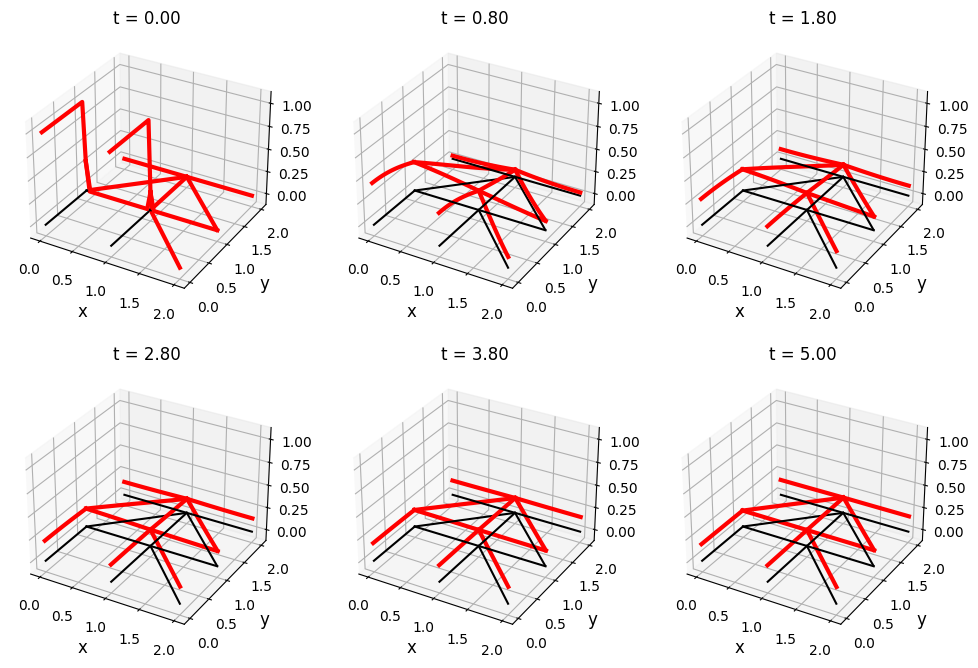

In [ ]:
"""  編集不要のセル  """

################
### プロット ###
################

fig = plt.figure(figsize = (12, 8))

plot_idx = [0]
for i_chunk in range(5):   
    plot_idx.append((i_chunk + 1) * len(tlist) // 5 - 1)

for ax_id in range(1,7):

    ax = fig.add_subplot(2, 3, ax_id, projection='3d')

    ax.set_title(f"t = {tlist[plot_idx[ax_id-1]]:03.2f}", size = 12)

    ax.set_xlabel("x", size = 12)
    ax.set_ylabel("y", size = 12)

    ax.set_zlim([-0.1, 1.1])

    for i in range(edge_num):
        # メトリックグラフのプロット（高さゼロ）
        ax.plot((L[i]-X[i])/L[i]*node_pos[edge[i][0]][0] + X[i]/L[i]*node_pos[edge[i][1]][0], 
                (L[i]-X[i])/L[i]*node_pos[edge[i][0]][1] + X[i]/L[i]*node_pos[edge[i][1]][1], 
                np.zeros(X[i].shape), color = "black")

        # メトリックグラフ上の数値解のプロット
        ax.plot((L[i]-X[i])/L[i]*node_pos[edge[i][0]][0] + X[i]/L[i]*node_pos[edge[i][1]][0], 
                (L[i]-X[i])/L[i]*node_pos[edge[i][0]][1] + X[i]/L[i]*node_pos[edge[i][1]][1], 
                U_save[plot_idx[ax_id-1]][i], color = "red", lw = 3)


In [ ]:
"""  編集不要のセル  """

##############################
### アニメーションプロット ###
##############################

fig = plt.figure(figsize = (4, 4))

ax = fig.add_subplot(1,1,1, projection='3d')

ax.set_xlabel("x", size = 12)
ax.set_ylabel("y", size = 12)

ax.set_zlim([-0.1, 1.1])

ims=[]

for t_id in range(len(tlist)):

    im = []
    for i in range(edge_num):
        # メトリックグラフのプロット（高さゼロ）
        im += ax.plot((L[i]-X[i])/L[i]*node_pos[edge[i][0]][0] + X[i]/L[i]*node_pos[edge[i][1]][0], 
                      (L[i]-X[i])/L[i]*node_pos[edge[i][0]][1] + X[i]/L[i]*node_pos[edge[i][1]][1], 
                       np.zeros(X[i].shape), color = "black")

        # メトリックグラフ上の数値解のプロット
        im += ax.plot((L[i]-X[i])/L[i]*node_pos[edge[i][0]][0] + X[i]/L[i]*node_pos[edge[i][1]][0], 
                      (L[i]-X[i])/L[i]*node_pos[edge[i][0]][1] + X[i]/L[i]*node_pos[edge[i][1]][1], 
                       U_save[t_id][i], color = "red", lw = 3)

    ims.append(im)


# ArtistAnimationにfigオブジェクトとimsを代入してアニメーションを作成
anim = animation.ArtistAnimation(fig, ims, interval=300)

# Google Colaboratoryの場合必要
rc('animation', html='jshtml')
plt.close()
anim

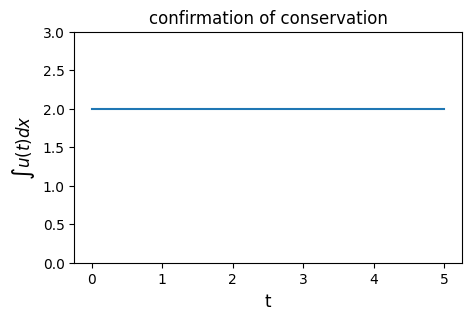

In [ ]:
"""  編集不要のセル  """

# 熱拡散方程式なので数値的な積分値が保存していることの確認
num_integral = []
for t_id in range(len(tlist)):
    tmp_integral = 0
    for edge_id in range(edge_num):
        tmp_integral += sum((U_save[t_id][edge_id][1:]+U_save[t_id][edge_id][:-1])/2) * dx

    num_integral.append(tmp_integral)

fig = plt.figure(figsize = (5, 3))

ax = fig.add_subplot()

ax.set_title("confirmation of conservation")

ax.set_xlabel("t", size = 12)
ax.set_ylabel("$\int{u(t)}dx$", size = 12)

ax.set_ylim([0, max(num_integral)+1])

ax.plot(tlist, num_integral)

plt.show()